In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

### Datasets

JFLEG: https://huggingface.co/datasets/jfleg <br>
tmu_gfm (take those that < 3 avg_g?): https://huggingface.co/datasets/tmu_gfm_dataset <br>
wi_locness (take text as hyp and edits as original): https://huggingface.co/datasets/wi_locness <br>
c4_200m (take input as hyp and output as original): https://huggingface.co/datasets/liweili/c4_200m <br>
c4_200m_100k (should be a sampled version of the last one): https://huggingface.co/datasets/leslyarun/c4_200m_gec_train100k_test25k

5 баллов дается за: 
- Анализ проблемы (что за задача решается, почему она важна) 
- EDA датасета (дисбаланс, метрики, особенности) 
- Сделали модель ML с использованием предобученных или обученных эмбеддингов 

6 баллов: 
- Использовали deep learning модель (RNN и/или CNN) 

7 баллов: 
- Использовали hugging face предобученную модель 

8 баллов: 
- Сделали аналитику подходов/моделей, которые есть 

9 баллов: 
- Оформили решение в красивом ноутбуке с графиками на гитхаб или на kaggle 

10 баллов: 
- Подключили wandb и/или gradio

So there is quite a few open-source datasets to be used in GEC (Grammatical Error Correction) task, mainly:
- [JFLEG](https://huggingface.co/datasets/jfleg) <br>
- [tmu_gfm](https://huggingface.co/datasets/tmu_gfm_dataset) (take those that < 3 avg_g?) <br>
- [wi_locness](https://huggingface.co/datasets/wi_locness) (take text as hyp and edits as original) <br>
- [c4_200m](https://huggingface.co/datasets/liweili/c4_200m) (take input as hyp and output as original) <br>
- [c4_200m_100k](https://huggingface.co/datasets/leslyarun/c4_200m_gec_train100k_test25k) (should be a sampled version of the previous one)

So, after serious consideration, [wi_locness](https://huggingface.co/datasets/wi_locness) was deemed to be the most fitting (largely based on my strange preferences)

Here is some dataset info (directly from dataset summary) of **wi** subset:
> Write & Improve (Yannakoudakis et al., 2018) is an online web platform that assists non-native English students with their writing. Specifically, students from around the world submit letters, stories, articles and essays in response to various prompts, and the W&I system provides instant feedback. Since W&I went live in 2014, W&I annotators have manually annotated some of these submissions and assigned them a CEFR level.


Data Fields

The fields of the dataset are:

    id: the id of the text as a string
    cefr: the CEFR level of the text as a string
    userid: id of the user
    text: the text of the submission as a string
    edits: the edits from W&I:
        start: start indexes of each edit as a list of integers
        end: end indexes of each edit as a list of integers
        text: the text content of each edit as a list of strings
        from: the original text of each edit as a list of strings

In [2]:
from datasets import load_dataset

dataset = load_dataset('wi_locness', 'wi')

c:\Users\marem\dev\mamba\envs\nn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print('Train shape: ', dataset['train'].shape)
print('Valid shape: ', dataset['validation'].shape)

Train shape:  (3000, 5)
Valid shape:  (300, 5)


In [4]:
# data sample example

print(dataset['train'][0])

{'id': '1-140178', 'userid': '21251', 'cefr': 'A2.i', 'text': 'My town is a medium size city with eighty thousand inhabitants. It has a high density population because its small territory. Despite of it is an industrial city, there are many shops and department stores.  I recommend visiting the artificial lake in the certer of the city which is surrounded by a park. Pasteries are very common and most of them offer the special dessert from the city. There are a comercial zone along the widest street of the city where you can find all kind of establishments: banks, bars, chemists, cinemas, pet shops, restaurants, fast food restaurants, groceries, travel agencies, supermarkets and others. Most of the shops have sales and offers at least three months of the year: January, June and August. The quality of the products and services are quite good, because there are a huge competition, however I suggest you taking care about some fakes or cheats.', 'edits': {'start': [13, 77, 104, 126, 134, 25

In [5]:
# some text transformations to acquire 'correct' text from 'edits' field

def text_transform(data):
    correct_text = ""
    prev_end = 0
    for clean_text, start, end in zip(data['edits']['text'], data['edits']['start'], data['edits']['end']):
        if clean_text is None:
            correct_text += data['text'][prev_end:end]
        else:
            correct_text += data['text'][prev_end:start] + clean_text
        prev_end = end
    correct_text += data['text'][prev_end:]
    return correct_text

In [6]:
dataset = dataset.map(
    lambda item: {
        "correct": text_transform(item)
    }
)

In [7]:
print('Corrupted sample:', dataset['train']['text'][0])
print('Correct sample:', dataset['train']['correct'][0])

Corrupted sample: My town is a medium size city with eighty thousand inhabitants. It has a high density population because its small territory. Despite of it is an industrial city, there are many shops and department stores.  I recommend visiting the artificial lake in the certer of the city which is surrounded by a park. Pasteries are very common and most of them offer the special dessert from the city. There are a comercial zone along the widest street of the city where you can find all kind of establishments: banks, bars, chemists, cinemas, pet shops, restaurants, fast food restaurants, groceries, travel agencies, supermarkets and others. Most of the shops have sales and offers at least three months of the year: January, June and August. The quality of the products and services are quite good, because there are a huge competition, however I suggest you taking care about some fakes or cheats.
Correct sample: My town is a medium-sized city with eighty thousand inhabitants. It has a hi

In [326]:
import re
import nltk.corpus
import sys

# some simple tokenization preprocessing
# not using lemmatization and stopwords so as to not simplify model to produce base words

def clean_text(text, deploy):
  text = text.strip()
  if not deploy:
    # removes links (e.g. https://site.com)
    text = re.sub(r"(\w+:\/\/\S+)|^rt|http.+?", "", text)
    # removes all chars but latin letters, dash and space
    text = re.sub(r"[^a-zA-Z- ]+", "", text)
  # replaces every capital character to it's lower version (except the first character in each word)
  # e.g. Hello NEW-YOrk HOw aRe yoU -> Hello New-York How are you
  text = re.sub(r"\B\w", lambda x: x.group().lower(), text)
  return text

# default NLTK sent_tokenize for english
sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
# to also sentence-tokenize by some abbreviations
sent_tokenizer._params.abbrev_types.update(['dr', 'vs', 'mr', 'mrs', 'prof', 'inc', 'i.e', 'e.g'])
word_tokenizer = nltk.tokenize.WhitespaceTokenizer()

def complex_tokenizer(text, deploy=False, max_snt_len=sys.maxsize):
    # basic sentence tokenizer
    snts = sent_tokenizer.tokenize(text)
    # + tokenize additional sentences by '\n'
    new_snts = []
    for snt in snts:
        snt = snt.split('\n')
        new_snts.extend(snt)
    # sentence cleaning + word tokenization
    new_snts = [word_tokenizer.tokenize(clean_text(snt, deploy)[:max_snt_len]) for snt in new_snts]
    # filter out empty snts
    new_snts = list(filter(lambda x: len(x) > 0, new_snts))
    return new_snts

In [239]:
# 150 chars is roughly equivalent to 32 words (4.7 chars per word avg) which is quite enough for the sentence
# will filter out otherones so that they won't make our statistic look bad
# MAX_LENGTH = 150

dataset = dataset.map(
    lambda item: {
        "tokenized-corrupted": complex_tokenizer(item["text"]),
        "tokenized-correct": complex_tokenizer(item["correct"])
    }
)

Map: 100%|██████████| 300/300 [00:00<00:00, 859.27 examples/s] 


In [240]:
print('Corrupted text:', dataset['train']['text'][0])
print('Corrupted tokens:', dataset['train']['tokenized-corrupted'][0])
print('Correct text:', dataset['train']['correct'][0])
print('Correct tokens:', dataset['train']['tokenized-correct'][0])

Corrupted text: My town is a medium size city with eighty thousand inhabitants. It has a high density population because its small territory. Despite of it is an industrial city, there are many shops and department stores.  I recommend visiting the artificial lake in the certer of the city which is surrounded by a park. Pasteries are very common and most of them offer the special dessert from the city. There are a comercial zone along the widest street of the city where you can find all kind of establishments: banks, bars, chemists, cinemas, pet shops, restaurants, fast food restaurants, groceries, travel agencies, supermarkets and others. Most of the shops have sales and offers at least three months of the year: January, June and August. The quality of the products and services are quite good, because there are a huge competition, however I suggest you taking care about some fakes or cheats.
Corrupted tokens: [['My', 'town', 'is', 'a', 'medium', 'size', 'city', 'with', 'eighty', 'thou

In [219]:
# making some stats

data_stats = {}
for data_type in ['train', 'validation']:
  data_stats[data_type] = {}
  for token_type in ['corrupted', 'correct']:
    data_stats[data_type][token_type] = {}
    snt_len = {}
    word_len = {}
    for text in dataset[data_type][f'tokenized-{token_type}']:
      for snt in text:
        if len(snt) not in snt_len:
          snt_len[len(snt)] = 1
        snt_len[len(snt)] += 1
        for word in snt:
          if len(word) not in word_len:
            word_len[len(word)] = 1
          word_len[len(word)] += 1
    data_stats[data_type][token_type]['snt'] = snt_len
    data_stats[data_type][token_type]['word'] = word_len

train corrupted: Sentence length range[1:222]
train correct: Sentence length range[1:102]
validation corrupted: Sentence length range[1:220]
validation correct: Sentence length range[1:109]


Text(0.5, 0.98, 'Sentence length distribution (in words)')

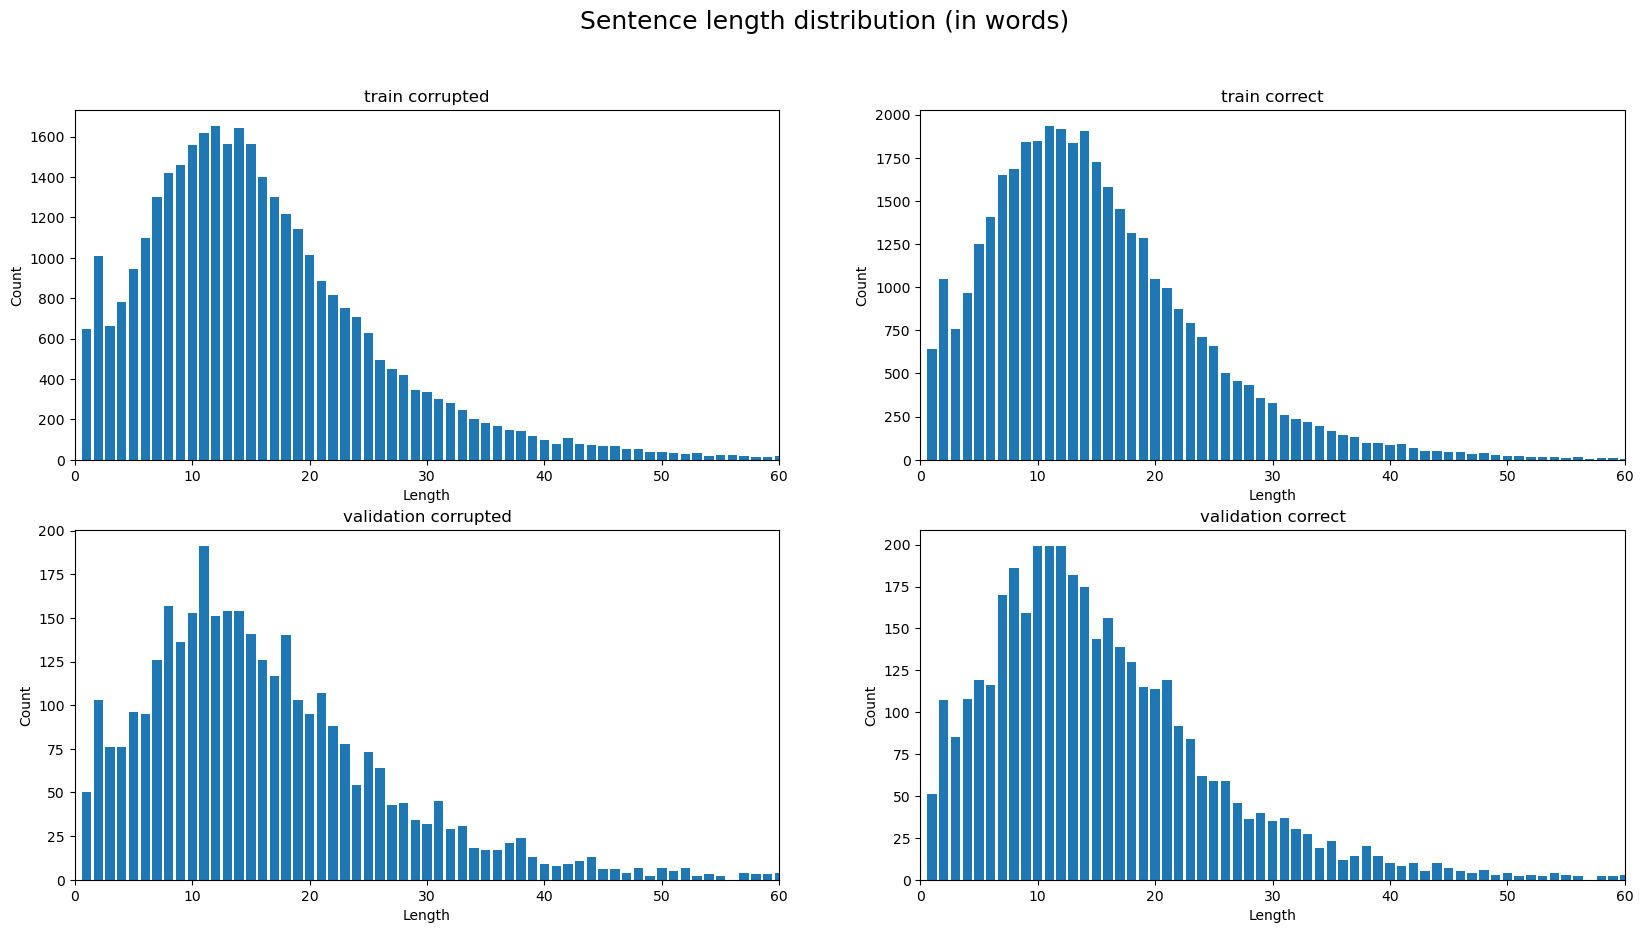

In [220]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for i, data_type in enumerate(['train', 'validation']):
  for j, token_type in enumerate(['corrupted', 'correct']):
    snt_len = data_stats[data_type][token_type]['snt']
    word_len = data_stats[data_type][token_type]['word']
    print(f'{data_type} {token_type}: Sentence length range[{min(snt_len.keys())}:{max(snt_len.keys())}]')
    ax[i][j].bar(snt_len.keys(), snt_len.values())
    ax[i][j].set_title(f'{data_type} {token_type}')
    ax[i][j].set_xlabel('Length')
    ax[i][j].set_ylabel('Count')
    ax[i][j].set_xlim(0, 60)
fig.suptitle('Sentence length distribution (in words)', fontsize=18)

train corrupted: Word length range[1:69]
train correct: Word length range[1:69]
validation corrupted: Word length range[1:30]
validation correct: Word length range[1:24]


Text(0.5, 0.98, 'Word length distribution (in chars)')

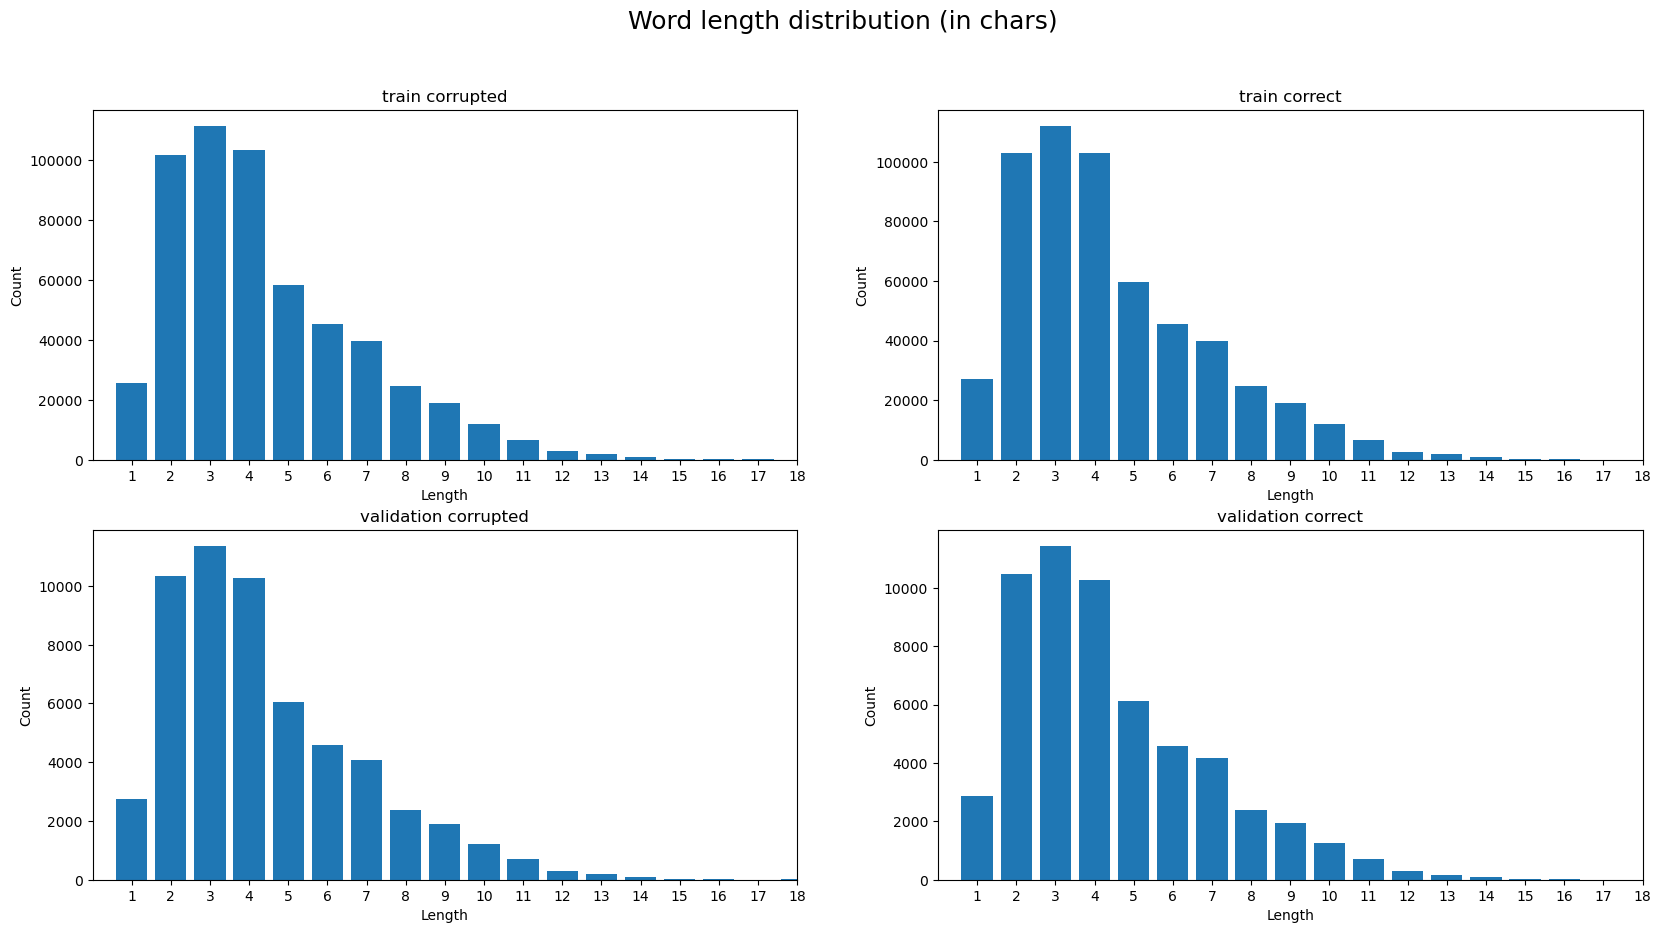

In [221]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for i, data_type in enumerate(['train', 'validation']):
  for j, token_type in enumerate(['corrupted', 'correct']):
    snt_len = data_stats[data_type][token_type]['snt']
    word_len = data_stats[data_type][token_type]['word']
    print(f'{data_type} {token_type}: Word length range[{min(word_len.keys())}:{max(word_len.keys())}]')
    ax[i][j].bar(word_len.keys(), word_len.values())
    ax[i][j].set_title(f'{data_type} {token_type}')
    ax[i][j].set_xlabel('Length')
    ax[i][j].set_ylabel('Count')
    ax[i][j].set_xticks([i for i in range(1, len(word_len.keys())+1)])
    ax[i][j].set_xlim(0, 18)
fig.suptitle('Word length distribution (in chars)', fontsize=18)

In [222]:
for sample in dataset['train']:
    for snt in sample['tokenized-correct']:
        for word in snt:
            if len(word) > 20:
                print(word)

environment-conscious
Europeseklerlandsubject
carbon-level-increasing
environmentally-friendly
internal-combustion-powered
---------------------------------------------------------------------
environmentally-friendly
environmentally-friendly
environmentally-friendly
wwwelihinkelorgtipstenseshtm
climateweather-related
culturally-conditioned
carbon-dioxide-storing
environmentally-friendly


Text(0.5, 0.98, 'Word clouds')

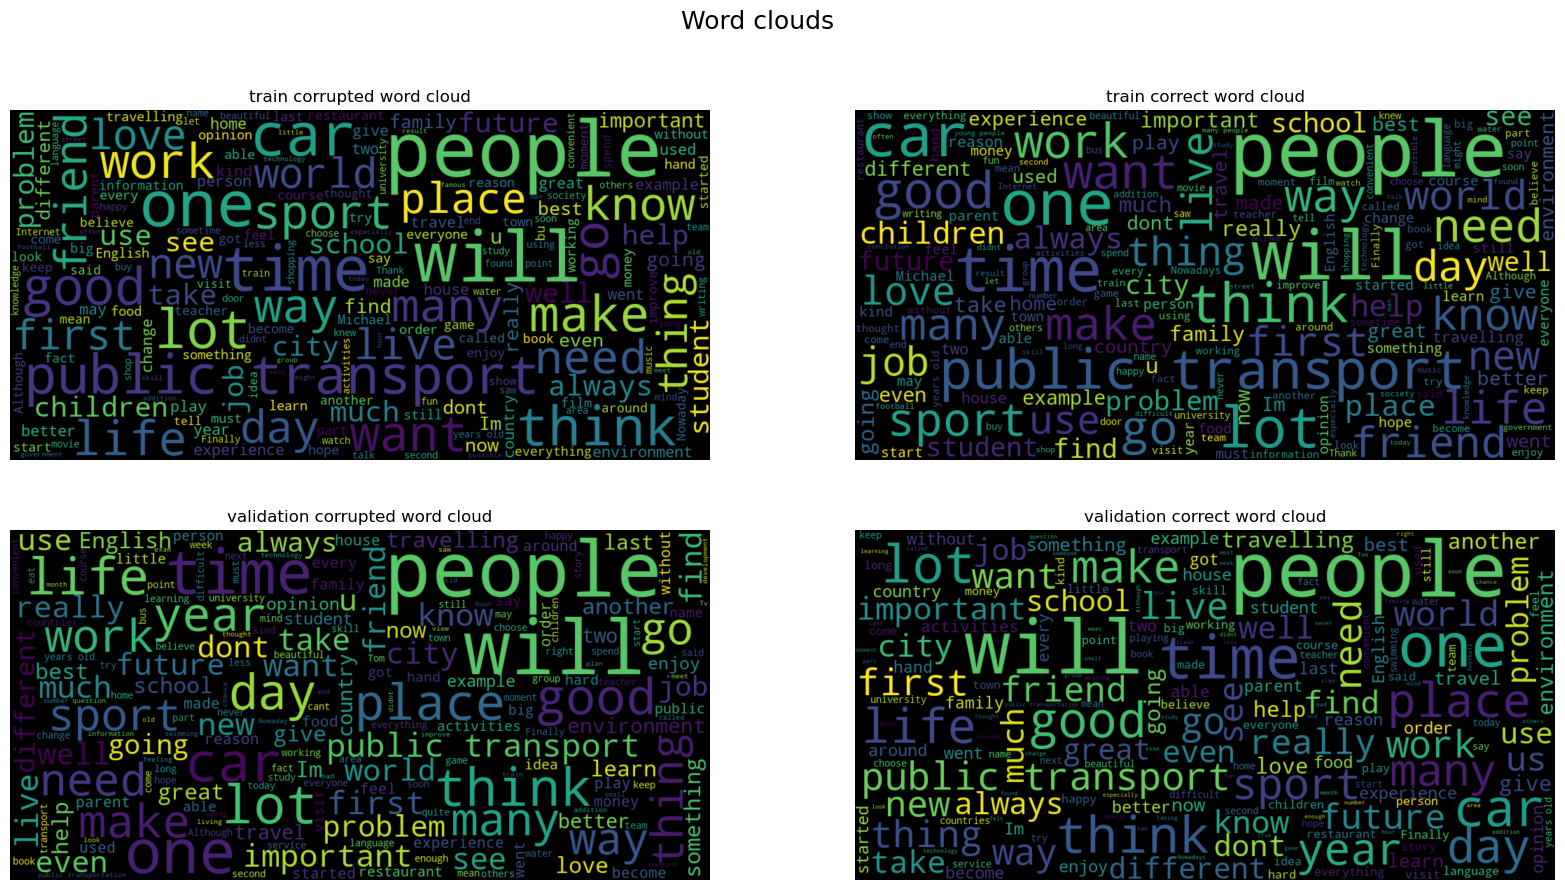

In [223]:
from wordcloud import WordCloud

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for i, data_type in enumerate(['train', 'validation']):
  for j, token_type in enumerate(['corrupted', 'correct']):
    all_texts = ""
    for text in dataset[data_type][f'tokenized-{token_type}']:
        for snt in text:
            all_texts += " ".join(snt) + " "
            
    wordcloud = WordCloud(width=1000, height=500, random_state=42, max_font_size=110).generate(all_texts)
    ax[i][j].imshow(wordcloud, interpolation="bilinear")
    ax[i][j].set_title(f'{data_type} {token_type} word cloud')
    ax[i][j].axis('off')
fig.suptitle('Word clouds', fontsize=18)

In [224]:
for i, data_type in enumerate(['train', 'validation']):
  data_stats[data_type]['word_error'] = {}
  for sample in dataset[data_type]:
    word_errors = {}
    for snt in sample['tokenized-correct']:
        for word in snt:
          if word not in word_errors:
            word_errors[word] = 0
          word_errors[word] += 1
    for snt in sample['tokenized-corrupted']:
        for word in snt:
          if word in word_errors:
            word_errors[word] -= 1
    if sample['cefr'] not in data_stats[data_type]['word_error']:
       data_stats[data_type]['word_error'][sample['cefr']] = [0, 0]
    data_stats[data_type]['word_error'][sample['cefr']][0] += sum(list(map(lambda x: max(0, x), word_errors.values())))
    data_stats[data_type]['word_error'][sample['cefr']][1] += sum(map(len, sample['tokenized-correct']))

Text(0.5, 0.98, 'Token error distribution')

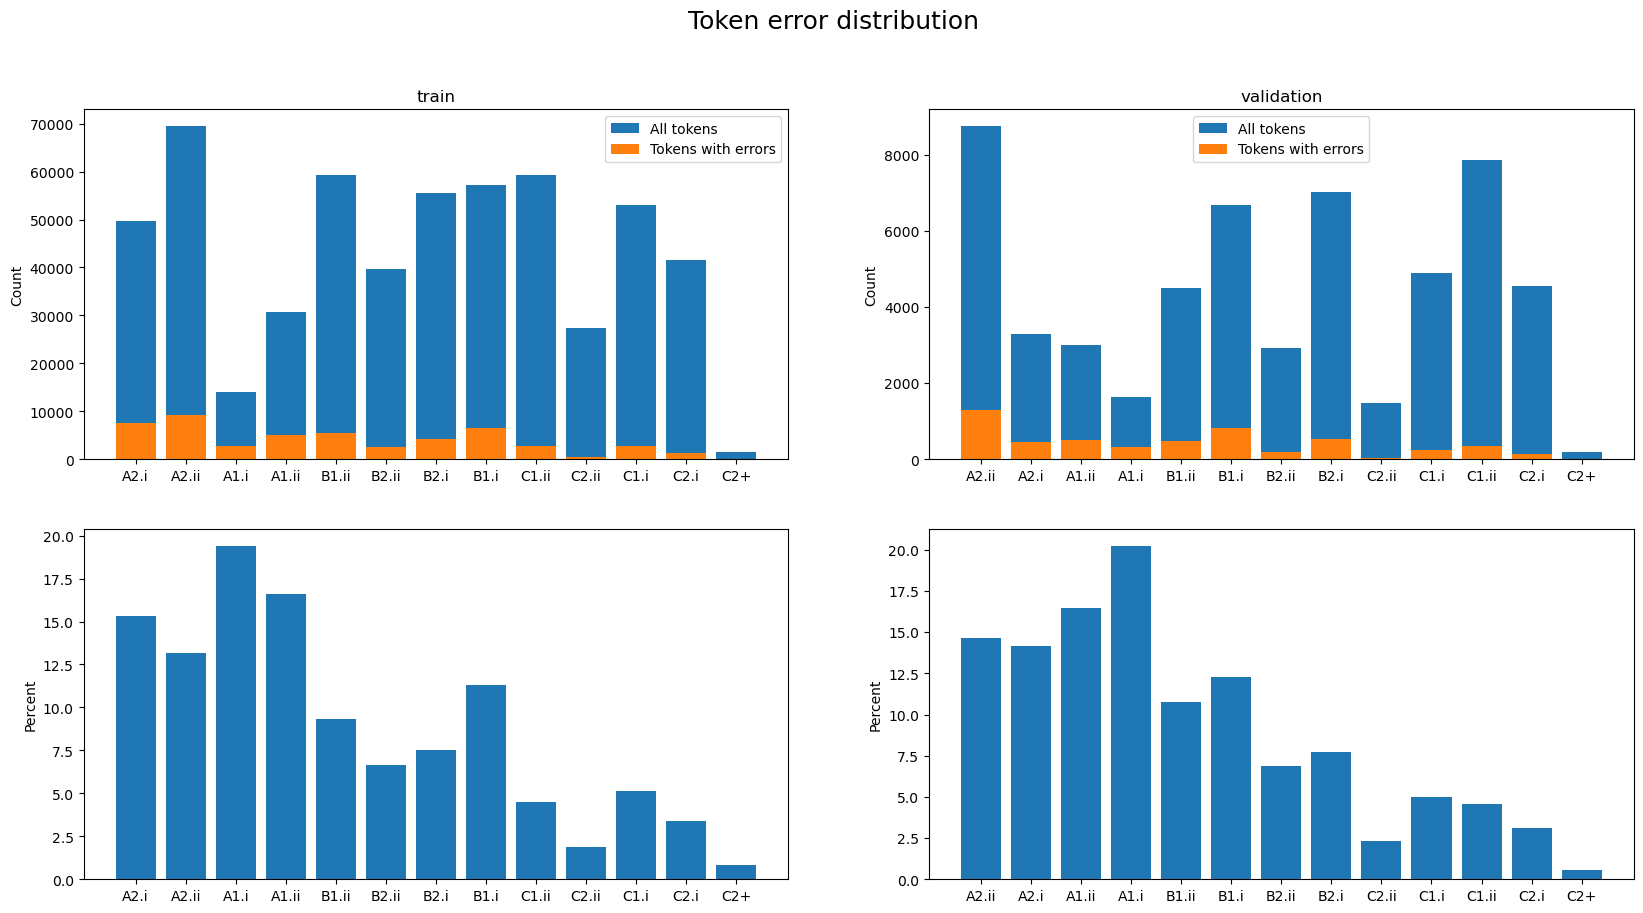

In [225]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.flatten()
for i, data_type in enumerate(['train', 'validation']):
    ax[i].bar(data_stats[data_type]['word_error'].keys(), list(map(lambda x: x[1], data_stats[data_type]['word_error'].values())), label='All tokens')
    ax[i].bar(data_stats[data_type]['word_error'].keys(), list(map(lambda x: x[0], data_stats[data_type]['word_error'].values())), label='Tokens with errors')
    ax[i].set_title(data_type)
    ax[i].set_ylabel('Count')
    ax[i].legend()
    ax[i+2].bar(data_stats[data_type]['word_error'].keys(), list(map(lambda x: x[0] / x[1] * 100, data_stats[data_type]['word_error'].values())))
    ax[i+2].set_ylabel('Percent')
fig.suptitle('Token error distribution', fontsize=18)

Overall presented stats adhere to typical english writing (sentence / word len distribution) and dataset manual labelling (i.e. CEFR labelling)

### Initializing models

#### Embedding similarity (based on fasttext)

In [68]:
from gensim.models import FastText

fasttext = FastText(
    vector_size=300, 
    window=5, 
    min_count=1, 
    sg=1, 
    negative=10, 
    min_n=1, 
    max_n=2,
    workers=20, 
    seed=42
    )

In [69]:
all_train_snts = []
for snts in dataset['train']['tokenized-correct']:
    all_train_snts += snts
for snts in dataset['train']['tokenized-corrupted']:
    all_train_snts += snts
len(all_train_snts)

71447

In [70]:
fasttext.build_vocab(corpus_iterable=all_train_snts)
fasttext.train(corpus_iterable=all_train_snts, total_examples=len(all_train_snts), epochs=50)

(42422198, 55558350)

In [120]:
print(dataset['train']['tokenized-corrupted'][10][10])
print(dataset['train']['tokenized-correct'][10][10])

IndexError: list index out of range

In [96]:
'language' in fasttext.wv.key_to_index

True

In [99]:
fasttext.wv.most_similar('language')[0][0]

'lenguage'


#### symspellpy

link: https://github.com/mammothb/symspellpy

##### Preprocessing

In [31]:
from collections import Counter

def make_bigrams(tokenized_text, neighbours=1):
    bigrams = []
    for text in tokenized_text:
        for snt in text:
            for i in range(len(snt)-neighbours):
                for j in range(1, neighbours+1):
                    bigrams.append((snt[i], snt[i+j]))
    return bigrams

def make_tokens_freq(tokenized_text, neighbours=1):
    tokens = []
    for text in tokenized_text:
        for snt in text:
            tokens += snt
    term_freq = Counter(tokens)
    bigrams_freq = Counter(make_bigrams(tokenized_text, neighbours))
    return term_freq, bigrams_freq

In [33]:
term_freq, bigram_freq = make_tokens_freq(dataset['train']['tokenized-correct'])

In [34]:
print(sorted(list(term_freq.items()), key=lambda x: x[1], reverse=True)[:5])
print(sorted(list(bigram_freq.items()), key=lambda x: x[1], reverse=True)[:5])

[('the', 24107), ('to', 18422), ('and', 16024), ('a', 13444), ('I', 12758)]
[(('in', 'the'), 2556), (('of', 'the'), 2426), (('I', 'am'), 1295), (('to', 'the'), 1294), (('it', 'is'), 1256)]


In [35]:
def make_freq_file(term_freq, bigram_freq, term_filepath, bigram_filepath):
    term_freq_list = list(term_freq.items())
    term_text = ""
    for term, freq in term_freq_list:
        term_text += f'{term} {freq}\n'
    with open(term_filepath, 'w') as file:
        file.write(term_text)
    bigram_freq_list = list(bigram_freq.items())
    bigram_text = ""
    for (first, second), freq in bigram_freq_list:
        bigram_text += f'{first} {second} {freq}\n'
    with open(bigram_filepath, 'w') as file:
        file.write(bigram_text)

In [36]:
make_freq_file(term_freq, bigram_freq, './term_freq.txt', './bigram_freq.txt')

##### Initialization

In [38]:
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell()

In [39]:
sym_spell.load_dictionary('./term_freq.txt', 0, 1)

True

In [40]:
sym_spell.load_bigram_dictionary('./bigram_freq.txt', 0, 2)

True

In [41]:
sym_spell.word_count, len(sym_spell.bigrams)

(20908, 170999)

In [42]:
sym_spell_example = sym_spell.lookup('hel', Verbosity.CLOSEST, max_edit_distance=2, transfer_casing=True)
print('lookup:')
for suggestion in sym_spell_example:
    print('\t', suggestion)
# basically the same thing but with some tokenization and most frequent token returned (Verbosity.TOP)
sym_spell_example = sym_spell.lookup_compound('hel', max_edit_distance=2, transfer_casing=True)
print('lookup_compound:')
for suggestion in sym_spell_example:
    print('\t', suggestion)

lookup:
	 he, 1, 1866
	 her, 1, 1003
	 help, 1, 579
	 held, 1, 28
	 hes, 1, 27
	 hell, 1, 14
	 del, 1, 11
	 hed, 1, 8
	 del, 1, 4
	 heal, 1, 2
	 mel, 1, 2
	 tel, 1, 1
	 pel, 1, 1
lookup_compound:
	 he, 1, 1866



#### NeuSpell

Link: https://github.com/neuspell/neuspell

In [88]:
from neuspell import SclstmChecker

neuspell_checker = SclstmChecker()
neuspell_checker.from_pretrained('scrnn-probwordnoise')

data folder is set to `c:\Users\marem\dev\mamba\envs\nn\lib\site-packages\neuspell\../data` script
loading vocab from path:scrnn-probwordnoise\vocab.pkl
initializing model
SCLSTM(
  (lstmmodule): LSTM(294, 512, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (dense): Linear(in_features=1024, out_features=100002, bias=True)
  (criterion): CrossEntropyLoss()
)
112111266
loading pretrained weights from path:scrnn-probwordnoise
Loading model params from checkpoint dir: scrnn-probwordnoise


In [89]:
neuspell_checker.correct_strings(['Stop doig this righ now'])

###############################################
data size: 1
total inference time for this data is: 0.071991 secs


c:\Users\marem\dev\mamba\envs\nn\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


['Stop doing this right now']


#### Happy Transformer

Link: https://github.com/EricFillion/happy-transformer

In [90]:
from happytransformer import  HappyTextToText
from happytransformer import TTSettings
# original model_name = "vennify/t5-base-grammar-correction" (was loaded and saved locally)
happy_tt = HappyTextToText("T5", "happy.pth")
happy_tt_settings = TTSettings(num_beams=5, min_length=1, max_length=100)

12/26/2023 13:13:58 - INFO - happytransformer.happy_transformer -   Using device: cuda:0


In [91]:
happy_example = happy_tt.generate_text('grammar: ' + ' '.join(['Stop doig this righ now']), args=happy_tt_settings)
print(happy_example.text)

12/26/2023 13:13:58 - INFO - happytransformer.happy_transformer -   Moving model to cuda:0
12/26/2023 13:13:58 - INFO - happytransformer.happy_transformer -   Initializing a pipeline


Stop doing this right now.



### Models evaluation


In [226]:
import jiwer

def evaluate(refs, hyps, eval_wer=True, eval_cer=True, eval_gleu=True):
    # refs - reference
    #   Example ['word']: [word1_ref, word2_ref]
    #   Example ['sentence']: [snt1_ref, snt2_ref]
    # hyps - hypothesis
    #   Example ['word']: [[word1_hyp1, word1_hyp2], [word2_hyp1, word2_hyp2]]
    #   Example ['sentence']: [[snt1_hyp1, snt1_hyp2], [snt2_hyp1, snt2_hyp2]]
    # evaluate_type
    #########################################
    wers = []
    cers = []
    gleus = []
    for ref, hyp in zip(refs, hyps):
        # to account for mean metric of each term
        # e.g. refs = ['Avocado', 'peach'], hyps = [['avoc', 'Avokadors', 'Avadokedavro'], ['peach']]
        # cer [no mean on ref] = [[0.57, 0.43, 1], [0]] -> [0.57, 0.43, 1, 0] -> 0.5
        # cer [mean on ref] = [[0.57, 0.43, 1], [0]] -> [0.67, 0] -> 0.34
        # cer [no mean on ref] is largely influenced by badly predicted refs with a large number of hyps
        # so we will use cer [mean on ref]
        ref_wers = []
        ref_cers = []
        ref_gleus = []
        for h in hyp:
            # error avoidance when reference is empty
            if len(ref) == 0:
                # still calculating error if hypothesis is not empty
                if len(h) != 0:
                    ref_wers.append(1)
                    ref_cers.append(1)
                    ref_gleus.append(0)
                continue
            # to avoid wer, cer > 1 influencing future mean calculation
            if eval_wer:
                wer = min(1, jiwer.wer(ref, h))
                ref_wers.append(wer)
            if eval_cer:
                cer = min(1, jiwer.cer(ref, h))
                ref_cers.append(cer)
            if eval_gleu:
                gleu = nltk.translate.gleu_score.sentence_gleu([h.split()], ref.split())
                ref_gleus.append(gleu)
        # max is used to avoid division by zero (e.g. when reference and hypothesis are both empty)
        wers.append(sum(ref_wers) / max(1, len(ref_wers)))
        cers.append(sum(ref_cers) / max(1, len(ref_cers)))
        gleus.append(sum(ref_gleus) / max(1, len(ref_gleus)))
    wer = sum(wers) / max(1, len(wers))
    cer = sum(cers) / max(1, len(cers))
    gleu = sum(gleus) / max(1, len(gleus)) 
    return wer, cer, gleu

In [227]:
print('evaluate [by word] example:')
wer, cer, gleu = evaluate(['Avocado', 'peach'], [['avoc', 'Avokadors', 'Avadokedavro'], ['peach']])
print('\twer:', wer)
print('\tcer:', cer)
print('\tgleu:', gleu)
print('evaluate [by sentence] example:')
wer, cer, gleu = evaluate(['Avocado should be good for your health'], [['avokado god health', 'avocado eat many many', 'Avocado is healthier', 'Avocado is good for your health']])
print('\twer:', wer)
print('\tcer:', cer)
print('\tgleu:', gleu)

evaluate [by word] example:
	wer: 0.5
	cer: 0.3333333333333333
	gleu: 0.5
evaluate [by sentence] example:
	wer: 0.75
	cer: 0.5460526315789473
	gleu: 0.14772727272727273


In [228]:
happy_tt.generate_text('grammar: ' + 'Hello my frend. How are u. What are u doing today?', args=happy_tt_settings).text

c:\Users\marem\dev\mamba\envs\nn\lib\site-packages\transformers\pipelines\base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


'Hello, my friend. How are you? What are you doing today?'

In [153]:
neuspell_checker.correct_strings(['Hello my frend', 'How are u'])

###############################################
data size: 2
total inference time for this data is: 0.032616 secs


c:\Users\marem\dev\mamba\envs\nn\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


['Hello my friend', 'How are you']

In [159]:
sym_pos_preds = sym_spell.lookup_compound('Hello my frend. How are u', max_edit_distance=2, transfer_casing=True)
sym_pred = ""
if len(sym_pos_preds) != 0:
    sym_pred = sym_pos_preds[0].term
sym_pred

'Hello my friend How are a'

In [315]:
import os, sys

# to silence neuspell atrocius logging (no verbose..)
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

def predict(test_snts, models=['fasttext', 'symspell', 'neuspell', 'happy']):
    fasttext_preds = []
    sym_preds = []
    neu_preds = []
    happy_preds = []

    # fasttext
    if 'fasttext' in models:
        for tokenized_snt in test_snts:
            fasttext_pred = []
            for word in tokenized_snt:
                fasttext_correct = word
                if word not in fasttext.wv.key_to_index:
                    fasttext_correct = fasttext.wv.most_similar(word)[0][0]
                fasttext_pred.append(fasttext_correct)
            fasttext_preds.append(' '.join(fasttext_pred))
        fasttext_preds = [['. '.join(fasttext_preds)]]

    snts = [' '.join(tokenized_snt) for tokenized_snt in test_snts]
    text = '. '.join(snts)
    # symspell
    if 'symspell' in models:
        sym_pred = []
        for snt in snts:
            sym_pos_preds = sym_spell.lookup_compound(snt, max_edit_distance=2, transfer_casing=True)
            sym_correct = ""
            if len(sym_pos_preds) != 0:
                sym_correct = sym_pos_preds[0].term
            sym_pred.append(sym_correct)
        sym_preds.append(['. '.join(sym_pred)])
    # neuspell
    if 'neuspell' in models:
        # silence loggings!
        with HiddenPrints():
            neu_pred = neuspell_checker.correct_strings(snts)
            #neu_preds = [[pred] for pred in neu_pred]
            neu_pred = '. '.join(neu_pred)
            neu_preds.append([neu_pred])
    # happy
    if 'happy' in models:
        happy_pred = happy_tt.generate_text('grammar: ' + text + '.', args=happy_tt_settings).text
        # replace end-sentence symbols with '.'
        happy_pred = re.sub(r"[!?]+", ".", text)
        # remove all symbols except good ones
        happy_pred = re.sub(r"[^a-zA-Z-. ]+", "", text)
        #happy_pred = complex_tokenizer(happy_pred)
        #happy_pred = [[' '.join(snt)] for snt in happy_pred]
        happy_preds.append([happy_pred])
    return fasttext_preds, sym_preds, neu_preds, happy_preds

In [316]:
model_names = ['fasttext', 'symspell', 'neuspell', 'happy']
pred_true_example = [['He', 'needed', 'me'], ['Stop', 'mapping', 'me'], ['Oh', 'world']]
pred_test_example = [['He', 'neded', 'me'], ['Stop', 'maping', 'me'], ['Oh', 'word']]
#eval_true = [' '.join(snt) for snt in pred_true_example]
eval_true = ['. '.join([' '.join(snt) for snt in pred_true_example])]
eval_test = [[' '.join(snt)] for snt in pred_test_example]
pred_pred_example = predict(pred_test_example)
print('\tpred [reference] example:', eval_true)
print('\tpred [source] example:', eval_test)
print('\tpred [hypothesis] example:')
for i, model_name in enumerate(model_names):
    print(f'\t\t{model_name}: {pred_pred_example[i]}')
print(f'\tevaluate:')
for i, model_name in enumerate(model_names):
    wer, cer, gleu = evaluate(eval_true, pred_pred_example[i])
    print(f'\t\t{model_name}:')
    print(f'\t\t\twer: {wer}')
    print(f'\t\t\tcer: {cer}')
    print(f'\t\t\tgleu: {gleu}')

	pred [reference] example: ['He needed me. Stop mapping me. Oh world']
	pred [source] example: [['He neded me'], ['Stop maping me'], ['Oh word']]
	pred [hypothesis] example:
		fasttext: [['He neded me. Stop taping me. Oh word']]
		symspell: [['He need me. Stop making me. Oh word']]
		neuspell: [['He needed me. Stop mapping me. Oh word']]
		happy: [['He neded me. Stop maping me. Oh word']]
	evaluate:
		fasttext:
			wer: 0.375
			cer: 0.10256410256410256
			gleu: 0.2692307692307692
		symspell:
			wer: 0.375
			cer: 0.1282051282051282
			gleu: 0.2692307692307692
		neuspell:
			wer: 0.125
			cer: 0.02564102564102564
			gleu: 0.8461538461538461
		happy:
			wer: 0.375
			cer: 0.07692307692307693
			gleu: 0.2692307692307692


In [318]:
%%time

metrics = {}
model_names = ['fasttext', 'symspell', 'neuspell', 'happy']
for model_name in model_names:
    metrics[model_name] = {
        'wer': [],
        'cer': [],
        'gleu': []
    }
for text in tqdm(dataset['validation']):
    preds = predict(text['tokenized-corrupted'])
    eval_true = ['. '.join([' '.join(snt) for snt in text['tokenized-correct']])]
    for i, model_name in enumerate(model_names):
        wer, cer, gleu = evaluate(eval_true, preds[i])
        metrics[model_name]['wer'].append(wer)
        metrics[model_name]['cer'].append(cer)
        metrics[model_name]['gleu'].append(gleu)

for model_name in model_names:
    wer = sum(metrics[model_name]['wer']) / max(1, len(metrics[model_name]['wer']))
    cer = sum(metrics[model_name]['cer']) / max(1, len(metrics[model_name]['cer']))
    gleu = sum(metrics[model_name]['gleu']) / max(1, len(metrics[model_name]['gleu']))
    print(f'{model_name}:')
    print(f'\twer: {wer}')
    print(f'\tcer: {cer}')
    print(f'\tgleu: {gleu}')

100%|██████████| 300/300 [10:17<00:00,  2.06s/it]

fasttext:
	wer: 0.15807491901260298
	cer: 0.08811378237406886
	gleu: 0.7222381752233443
symspell:
	wer: 0.16348326770506
	cer: 0.08106827601625727
	gleu: 0.7207994431682696
neuspell:
	wer: 0.15923557110169528
	cer: 0.08261020552827712
	gleu: 0.7319852801381033
happy:
	wer: 0.14493401323208152
	cer: 0.07690684162846124
	gleu: 0.7476668571761396
CPU times: total: 8min 29s
Wall time: 10min 17s


### Model deploying

In [328]:
complex_tokenizer('Hello frend. How are u?', deploy=True)

[['Hello', 'frend.'], ['How,', 'are', 'u?']]

In [330]:
# Hello my yung frend I m writiing to u from a fur away place! How r u?

import gradio as gr

models = [
    'fasttext',
    'symspell',
    'neuspell',
    'happy'
]

def app_predict(input_corrupt, input_true, model_name):
    pred = ""
    if model_name == 'fasttext':
        tokenized_snts = complex_tokenizer(input_corrupt, deploy=True)
        fasttext_preds = []
        for tokenized_snt in tokenized_snts:
            fasttext_pred = []
            for word in tokenized_snt:
                fasttext_correct = word
                if word not in fasttext.wv.key_to_index:
                    fasttext_correct = fasttext.wv.most_similar(word)[0][0]
                fasttext_pred.append(fasttext_correct)
            fasttext_preds.append(' '.join(fasttext_pred))
        pred = '. '.join(fasttext_preds)
    elif model_name == 'symspell':
        sym_pos_preds = sym_spell.lookup_compound(input_corrupt, max_edit_distance=2, transfer_casing=True)
        if len(sym_pos_preds) != 0:
            pred = sym_pos_preds[0].term
    elif model_name == 'neuspell':
        # silence loggings!
        with HiddenPrints():
            pred = neuspell_checker.correct_strings([input_corrupt])[0]
    else:
        pred = happy_tt.generate_text('grammar: ' + input_corrupt, args=happy_tt_settings).text
    wer, cer, gleu = evaluate([input_true], [[pred]])
    metric_str = f'wer: {wer}\n'
    metric_str += f'cer: {cer}\n'
    metric_str += f'gleu: {gleu}'
    return pred, metric_str

app = gr.Interface(fn=app_predict, inputs=[gr.Textbox(label='Input corrupted text'), gr.Textbox(label='Input correct text'), gr.Dropdown(models, value=models[0], label='Model selection')], outputs=[gr.Textbox(label='Output predicted text'), gr.Textbox(label='Output metrics')], title='Bad text to Good text', allow_flagging='never')

app.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


c:\Users\marem\dev\mamba\envs\nn\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
c:\Users\marem\dev\mamba\envs\nn\lib\site-packages\transformers\pipelines\base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


### Github

[github repository]()